In [ ]:
import sys

from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique, setdiff
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time
import requests
from desitarget import io, cuts

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

# Some handy, frequently used things
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"
global today
today = Time.now()

In [ ]:
# Borrowed from gw_skymap.py and modified

def plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra_obs=None, tile_dec_obs=None, tile_ra=None, tile_dec=None,):
    """Plot the DESI tiles
    
    Parameters
    ----------
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """

    # Open and close the temporary plot.
    #tfig   = plt.figure(num=2,figsize=figsize)
    #rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
    #                     lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
    #                     notext=True, xsize=1000,
    #                     return_projected_map=True)
    #plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1)
    #img = ax.imshow(rotimg, extent=[xmax, xmin, ymin, ymax],
    #                origin='lower', cmap='OrRd')

    ##for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
    #    p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(xmax, xmin),ylim=(ymin,ymax),\
       xlabel='RA [deg]',\
       ylabel='Dec [deg]')
    ax.grid(ls=':')
    



    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra_obs is not None and tile_dec_obs is not None:
        for _ra_c, _dec_c in zip(tile_ra_obs, tile_dec_obs):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
            ax.add_artist(circ)

    if tile_ra is not None and tile_dec is not None:
        for _ra_c, _dec_c in zip(tile_ra, tile_dec):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='r', ls='--', lw=2)
            ax.add_artist(circ)
            



    return fig

In [3]:
convs = dict.fromkeys([0,1,2,3,4,5,6,7,8,9,10], bytes.decode)

tiles = np.genfromtxt('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-main.ecsv',names=True,\
                      skip_header=18, dtype=(int,int,float, float, object,object, float, object, float, object, float,object, float), converters=convs)

In [131]:
tiles

array([( 1000, 0, 238.282,  0.   , 'DARK', 'True', 1.415 , 'done', 0.101, '15.91', 1.1687, b'True', 1.),
       ( 1001, 0, 270.   , 58.282, 'DARK', 'True', 0.945 , 'done', 0.044, '31.26', 1.0143, b'True', 1.),
       ( 1002, 0,   0.   , 31.717, 'DARK', 'True', 0.8202, 'unobs', 0.049, '8.29', 0.    , b'True', 1.),
       ...,
       (43083, 0, 128.878,  2.999, 'BACKUP', 'True', 0.9814, 'unobs', 0.033, '0.00', 0.    , b'True', 1.),
       (43084, 0, 157.041, -2.635, 'BACKUP', 'True', 0.9969, 'obsstart', 0.045, '0.00', 0.    , b'True', 1.),
       (43085, 0, 139.555, -6.181, 'BACKUP', 'True', 0.9622, 'unobs', 0.034, '0.00', 0.    , b'True', 1.)],
      dtype=[('TILEID', '<i8'), ('PASS', '<i8'), ('RA', '<f8'), ('DEC', '<f8'), ('PROGRAM', 'O'), ('IN_DESI', 'O'), ('PRIORITY', '<f8'), ('STATUS', 'O'), ('EBV_MED', '<f8'), ('DESIGNHA', 'O'), ('DONEFRAC', '<f8'), ('AVAILABLE', 'O'), ('PRIORITY_BOOSTFAC', '<f8')])

In [5]:
idx_done = ((tiles['STATUS']=='done') & (tiles['IN_DESI']=='True'))
idx_notdone = ((tiles['STATUS']!='done') & (tiles['IN_DESI']=='True'))

Text(0.5, 1.0, 'GAMA15 BRIGHT')

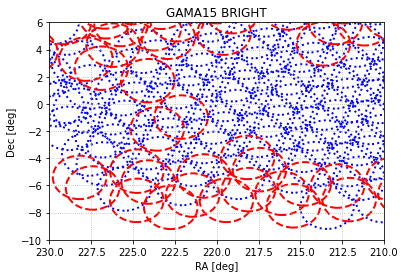

In [6]:
xmin,xmax = 210,230
ymin,ymax = -10,6
field='GAMA15'
program='BRIGHT'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)
#plt.savefig('desi_tile-matches.png', dpi=120)

Text(0.5, 1.0, 'GAMA15 + South DARK')

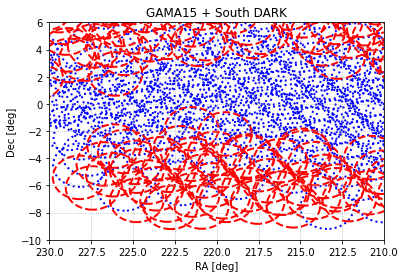

In [7]:
xmin,xmax = 210,230
ymin,ymax = -10,6
field='GAMA15 + South'
program='DARK'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)

Text(0.5, 1.0, 'Northern stripe DARK')

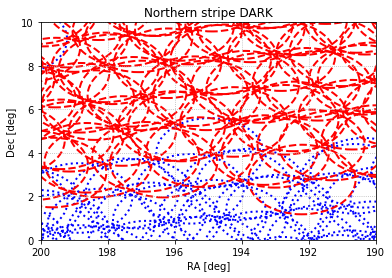

In [20]:
xmin,xmax = 190,200
ymin,ymax = 0,10
field='Northern stripe'
program='DARK'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)

Text(0.5, 1.0, 'Northern stripe BRIGHT')

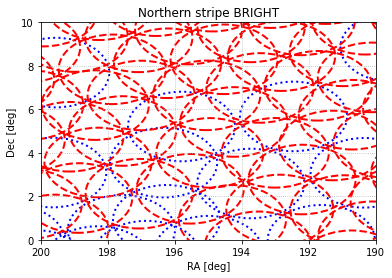

In [23]:
xmin,xmax = 190,200
ymin,ymax = 0,10
field='Northern stripe'
program='BRIGHT'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)

In [22]:
tiles['PASS'][idx_done & in_region]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Text(0.5, 1.0, 'Northern stripe DARK')

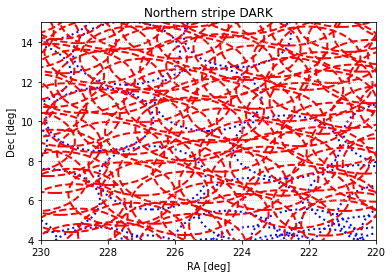

In [10]:
xmin,xmax = 220,230
ymin,ymax = 4,15
field='Northern stripe'
program='DARK'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)

Text(0.5, 1.0, 'Northern stripe BRIGHT')

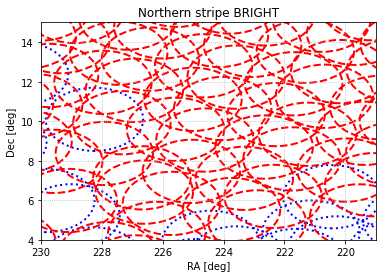

In [24]:
xmin,xmax = 219,230
ymin,ymax = 4,15
field='Northern stripe'
program='BRIGHT'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)

Text(0.5, 1.0, 'Northern stripe BRIGHT')

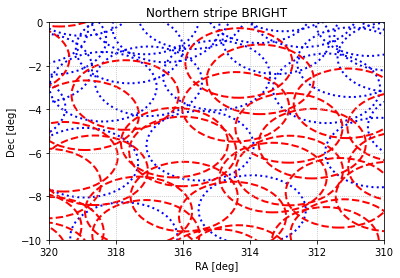

In [13]:
xmin,xmax = 310,320
ymin,ymax = -10,0
field='Northern stripe'
program='BRIGHT'

in_region = (tiles['RA']>xmin-5) & (tiles['RA']<xmax+5) & (tiles['DEC']>ymin-5) & (tiles['DEC']<ymax+5) & (tiles['PROGRAM']==program)

fig = plot_cartmap_tiles(xmin, xmax, ymin, ymax, tile_ra = tiles['RA'][idx_notdone & in_region], tile_dec = tiles['DEC'][idx_notdone & in_region], \
                        tile_ra_obs = tiles['RA'][idx_done & in_region], tile_dec_obs = tiles['DEC'][idx_done & in_region])
ax = fig.gca()
plt.title(field+' '+program)